# Simple Simulation Analysis

In this notebook I will analyse the output of a simple simulation. First, I load the output data of the two stations.

In [1]:
%matplotlib inline

import sys
sys.path.append('../')

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

from e_sim.sim_components import Simulator
from e_sim.utils import experiment_runner

## Run simulations

Run the simulation for several settings for the batch sizes and rates

In [7]:
# Common settings of the simulation
sim_time = 50

# Settings dict
settings = {}
settings['demand_rate'] = [1]
settings['repair_rate'] = [0.5]
settings['Q_service'] = [1,2]
settings['Q_repair'] = [1,2,3,4]
settings['S_depot'] = [2]
settings['S_warehouse'] = [2]
settings['init_stock_depot'] = [4]
settings['init_stock_warehouse'] = [2, 8]

# Run all combinations of experiments
sim_dfs = experiment_runner(settings, sim_time)

## Visualisation of stock over time

The stock levels of the repairable and servicable units are recorded over time. Let's check these.

In [8]:
# Get a feeling for the data
sim_dfs.head()

,time,service_stock_depot,service_orders,service_back_orders,service_stock_position,repair_stock_depot,service_stock_warehouse,repair_stock_warehouse,DEMAND,REPAIR,...,costs,Q_repair,Q_service,S_depot,S_warehouse,demand_rate,init_stock_depot,init_stock_warehouse,repair_rate,settings
0,1.0,3.0,0.0,0.0,3.0,0.0,2.0,0.0,1,0,...,0.15,1,1,2,2,1,4,2,0.5,"Q_repair=1, Q_service=1, S_depot=2, S_warehous..."
1,2.0,2.0,0.0,0.0,2.0,0.0,2.0,1.0,1,0,...,3.12,1,1,2,2,1,4,2,0.5,"Q_repair=1, Q_service=1, S_depot=2, S_warehous..."
2,2.5,2.0,0.0,0.0,2.0,0.0,3.0,0.0,0,1,...,0.15,1,1,2,2,1,4,2,0.5,"Q_repair=1, Q_service=1, S_depot=2, S_warehous..."
3,3.0,1.0,1.0,0.0,2.0,0.0,1.0,1.0,1,0,...,3.06,1,1,2,2,1,4,2,0.5,"Q_repair=1, Q_service=1, S_depot=2, S_warehous..."
4,3.5,1.0,1.0,0.0,2.0,0.0,1.0,0.0,0,1,...,0.06,1,1,2,2,1,4,2,0.5,"Q_repair=1, Q_service=1, S_depot=2, S_warehous..."


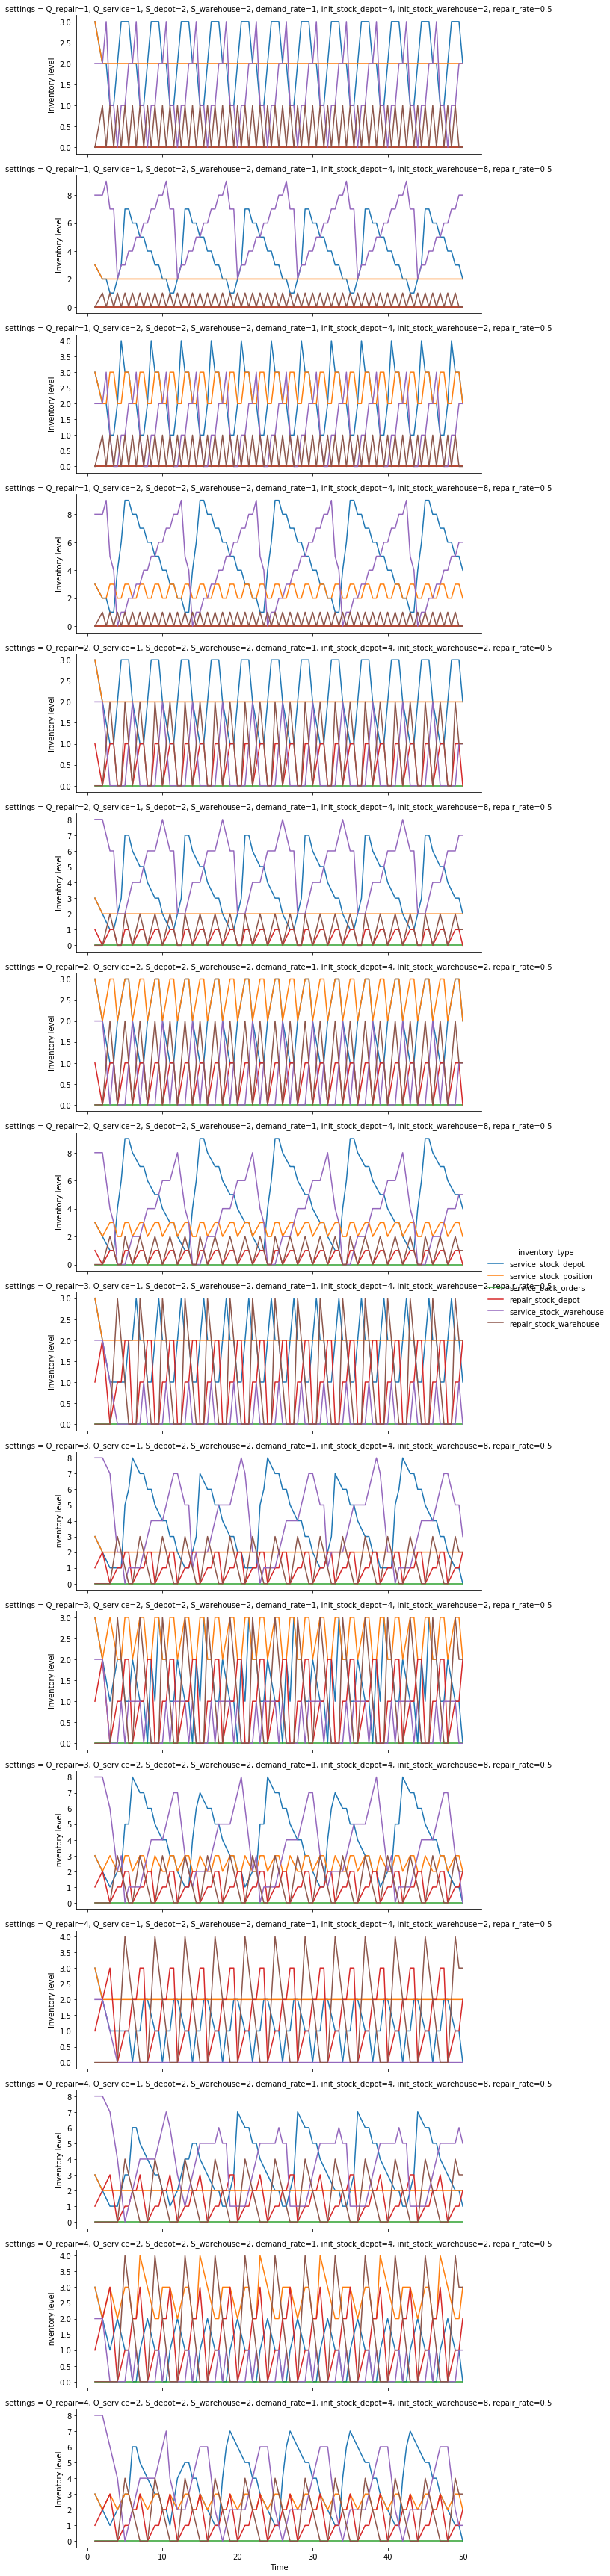

In [9]:
# Get all relevant inventory level variables
# Create long format
inventory_data = sim_dfs.melt(value_vars=['service_stock_depot', 'service_stock_position', 'service_back_orders', 'repair_stock_depot', 'service_stock_warehouse', 'repair_stock_warehouse'], 
                              id_vars=['time', 'settings'],
                              value_name='inventory_level', var_name='inventory_type'
                              )

# Plot lines over time 
g = sns.FacetGrid(inventory_data[inventory_data.time >= 0], col='settings', col_wrap=1, hue='inventory_type', aspect=3, sharey=False)

# Plot lines
g.map(plt.plot, 'time', 'inventory_level').add_legend().set_axis_labels('Time', 'Inventory level')

## Compute the average cycle cost

In this simple model, we assume that sending a batch from the warehouse to the depot has a cost `c_d` and sending a batch of repairable units from the depot to the warehouse costs `c_r`. In general we have that `c_r` > `c_d`, since the reverse flow is typically less efficient. Besides, set-up costs for orders, a holding costs of `h_d` per unit per unit of time for stock of servicable units at the depot has to be paid. In case of a shortage, a backlogging cost of `b_d` per unit per unit of time is incurred. For now, I do not assume any holding cost for the repairable units.

In [5]:
# Transform data types to float
sim_dfs.costs = sim_dfs.costs.astype(float)

# Total avg cost of simulation
sim_dfs.groupby(list(settings.keys())).agg({'costs':'mean'})

costs
demand_rate repair_rate Q_service Q_repair S_depot S_warehouse init_stock_depot init_stock_warehouse          
1           0.5         1         1        2       2           4                2                     2.101952
                                                                                8                     2.283969
                                  2        2       2           4                2                     2.359720
                                                                                8                     2.713196
                                  3        2       2           4                2                     2.057039
                                                                                8                     2.631623
                                  4        2       2           4                2                     2.315449
                                                                                8                     2.669778
                        2         1        2       2           4                2                     2.101937
                                                                                8                     2.283969
                                  2        2       2           4                2                     2.741768
                                                                                8                     2.750926
                                  3        2       2           4                2                     2.235486
                                                                                8                     2.632632
                                  4        2       2           4                2                     2.694653
                                                                                8                     2.866215

### Average inventory levels per cycle

In [6]:
sim_dfs.dtypes

time                       float64
service_stock_depot        float64
service_orders             float64
service_back_orders        float64
service_stock_position     float64
repair_stock_depot         float64
service_stock_warehouse    float64
repair_stock_warehouse     float64
DEMAND                       int64
REPAIR                       int64
SHIP_REPAIR                  int64
SHIP_SERVICE                 int64
order_cost_service           int64
order_cost_repair            int64
hold_cost_serviceables     float64
back_cost_serviceables     float64
hold_cost_repairables      float64
costs                      float64
Q_repair                     int64
Q_service                    int64
S_depot                      int64
S_warehouse                  int64
demand_rate                  int64
init_stock_depot             int64
init_stock_warehouse         int64
repair_rate                float64
settings                    object
dtype: object